In [48]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.fftpack import fft
from scipy.signal import argrelextrema
import pandas as pd

In [49]:
def sine_fit(x, y, plot=True, p0=True):
    """Estimate parameters of a noisy sine wave by FFT and non-linear fitting."""
    
    # Define the sine function
    def sine_func(x, offs, amp, f, phi):
        return offs + amp * np.sin(2 * np.pi * f * x + phi)
    
    # Estimate frequency using FFT
    N = len(y)
    f = np.linspace(0, 1, N)  # Frequency range
    yf = fft(y)
    estimate_f = f[np.argmax(np.abs(yf[1:N//2]))]  # Exclude offset
    
    # Initial guess for the parameters
    guess = [np.mean(y), np.std(y), estimate_f, 0]
    
    # Perform the fit
    if p0:
        popt, pcov = curve_fit(sine_func, x, y, p0=guess)
    else:
        popt, pcov = curve_fit(sine_func, x, y)
    
    # Calculate mean squared error
    mse = np.mean((y - sine_func(x, *popt)) ** 2)
    
    # Append MSE to parameters
    popt = np.append(popt, mse)
    
    # Plot if requested
    if plot:
        import matplotlib.pyplot as plt
        plt.figure()
        plt.plot(x, y,'o', 'b-', label='data')
        x = np.linspace(x[0], x[-1], 1000)
        plt.plot(x, sine_func(x, *popt[:-1]), 'r-', label='fit')
        plt.legend()
        plt.show()
    print(f'mse: {mse}')
    return popt

In [50]:
y = pd.read_csv('ccf_all_valid.csv', header=None).to_numpy()
x = pd.read_csv('lags.csv', header=None).to_numpy().flatten()
valid = pd.read_csv('valid_ccf.csv', header=None).to_numpy()

valid = np.array(valid, dtype=bool).flatten()
y_valid = y[valid]
y_invalid = y[~valid]
y_valid.shape

(502, 141)

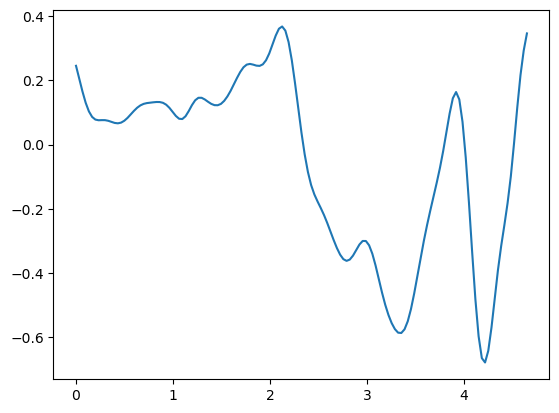

In [51]:
i = 461

plt.plot(x, y[i,:])

/home/roland/Schreibtisch/Capstone/.conda/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/roland/Schreibtisch/Capstone/.conda/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


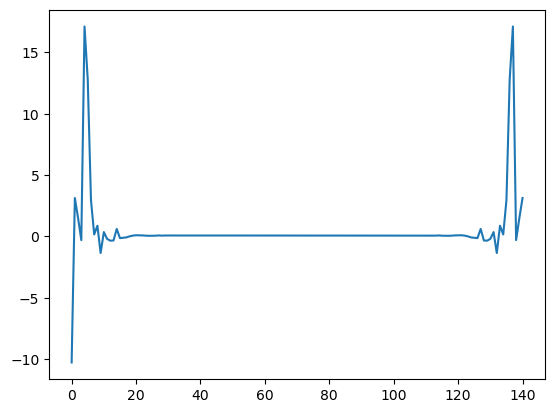

In [52]:

y_fft = fft(y_valid[i])
plt.plot(y_fft)

In [53]:
import ipywidgets as widgets
from IPython.display import display

In [54]:
def process_extrema(y_tmp, first_extremum_idx, second_extremum_idx, right_extremum_idx, factor):
    diff_left = np.abs(y_tmp[0]-y_tmp[first_extremum_idx])
    if factor != 0:
        if right_extremum_idx is not None:
            diff_right = np.abs(y_tmp[right_extremum_idx]-y_tmp[second_extremum_idx])
            diff = max(diff_left, diff_right) * factor
            diff_max = np.abs(y_tmp[first_extremum_idx]-y_tmp[second_extremum_idx])
            if diff_max < diff:
                diff = diff_max
            start = np.argmin(np.abs(y_tmp[:first_extremum_idx+1] - (y_tmp[first_extremum_idx] - diff)))
            end = second_extremum_idx + np.argmin(np.abs(y_tmp[second_extremum_idx+1:right_extremum_idx+1] - (y_tmp[second_extremum_idx] + diff))) + 1
        else:
            diff = diff_left
            start = np.argmin(np.abs(y_tmp[:first_extremum_idx+1] - (y_tmp[first_extremum_idx] - diff)))
            end = second_extremum_idx + np.argmin(np.abs(y_tmp[second_extremum_idx+1:] - (y_tmp[second_extremum_idx] + diff))) + 1
    return start, end



In [55]:
def plot_with_index(index, sinefit=False):
    y = y_valid[index]
    sinefit = sinefit
    # find local maxima
    max_idx = argrelextrema(y, np.greater)
    # find local minima
    min_idx = argrelextrema(y, np.less)

    # find first maximum and minimum
    max_1_idx = max_idx[0][0]
    min_1_idx = min_idx[0][0]
    factor=1/10

    # crop signal
    y_tmp = y.copy()
    y_tmp[y_tmp > y_tmp[max_1_idx]] = np.inf
    y_tmp[y_tmp < y_tmp[min_1_idx]] = np.inf
    
    if max_1_idx < min_1_idx:
        start = max_1_idx
        end = min_1_idx
        first_extremum = start
        second_extremum = end
        
        # find second maximum
        max_2_idx = max_idx[0][1]
        right_extremum_idx = max_2_idx
        
        diff_left = np.abs(y_tmp[0]-y_tmp[start])
        if factor != 0:
            diff_right = np.abs(y_tmp[max_2_idx]-y_tmp[end])
            diff = max(diff_left, diff_right) * factor
            diff_max = np.abs(y_tmp[first_extremum]-y_tmp[second_extremum])
            if diff_max < diff:
                diff = diff_max * factor
            start = np.argmin(np.abs(y_tmp[:start+1] - (y_tmp[max_1_idx] - diff)))
            end = end + np.argmin(np.abs(y_tmp[end+1:max_2_idx+1] - (y_tmp[min_1_idx] + diff))) + 1
            
    else:
        start = min_1_idx
        end = max_1_idx
        first_extremum = start
        second_extremum = end
        
        # find second minimum
        min_2_idx = min_idx[0][1] if len(min_idx[0]) > 1 else None
        right_extremum_idx = min_2_idx
    
        diff_left = np.abs(y_tmp[0]-y_tmp[start])
        if factor != 0:
            diff_right = np.abs(y_tmp[min_2_idx]-y_tmp[end])
            diff = max(diff_left, diff_right) * factor
            diff_max = np.abs(y_tmp[first_extremum]-y_tmp[second_extremum])
            if diff_max < diff:
                diff = diff_max * factor
            start = np.argmin(np.abs(y_tmp[:start+1] - (y_tmp[min_1_idx] + diff)))
            end = end + np.argmin(np.abs(y_tmp[end+1:min_2_idx+1] - (y_tmp[max_1_idx] - diff))) + 1
        
    y_crop = y[start:end+1]
    x_crop = x[start:end+1]
    if sinefit:
        # fit sine wave
        params = sine_fit(x_crop, y_crop, plot=False)
        print(params)
            
    x_fit = np.linspace(0, 2, 100)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax2.plot(x_crop, y_crop, 'o', lw=3)
    tmp = min(np.abs(start-2), start)
    ax2.set_xlim(x[tmp], x[end+2])
    ax2.set_ylim(min(y_crop)-0.2*(max(y_crop)-min(y_crop)), max(y_crop)*1.2)
    ax1.plot(x, y, 'o')
    ax1.vlines(x_crop[0], ymin=min(y), ymax=max(y), colors='k', linestyles='dashed')
    ax1.vlines(x_crop[-1], ymin=min(y), ymax=max(y), colors='k', linestyles='dashed')
    x_test = x[0:right_extremum_idx+1]
    y_test = y[0:right_extremum_idx+1]
    ax2.plot(x_test, y_test, 'o')
    ax2.hlines(y[max_1_idx]-diff, x_test[0], x_test[-1], 'b', ls='--')
    ax2.hlines(y[min_1_idx]+diff, x_test[0], x_test[-1], 'b', ls='--')
    ax2.vlines(x[min_1_idx], min(y_test), max(y_test), 'r', ls='--')
    ax2.vlines(x[max_1_idx], min(y_test), max(y_test), 'r', ls='--')
    ax2.plot([x[start], x[end]], [y[start], y[end]], 'o', color='m')
    # plot sine wave
    if sinefit:
        
        ax1.plot(x_fit, params[0] + params[1] * np.sin(2 * np.pi * params[2] * x_fit + params[3]), 'k--', lw=2)
        ax2.plot(x_fit, params[0] + params[1] * np.sin(2 * np.pi * params[2] * x_fit + params[3]), 'k--', lw=2)
        
        
    plt.show()
slider = widgets.IntSlider(min=0, max=len(y_valid)-1, step=1, value=0)
sinefit_checkbox = widgets.Checkbox(value=False, description='Sinefit')
widgets.interact(plot_with_index, index=slider, sinefit=sinefit_checkbox)



interactive(children=(IntSlider(value=0, description='index', max=501), Checkbox(value=False, description='Sin…

<function __main__.plot_with_index(index, sinefit=False)>

In [56]:
params[2]

NameError: name 'params' is not defined

In [ ]:

x_test = x[0:right_extremum_idx+1]
y_test = y[0:right_extremum_idx+1]
plt.plot(x_test, y_test, 'o')
plt.hlines(y[max_1_idx]-diff, x_test[0], x_test[-1], 'b', ls='--')
plt.hlines(y[min_1_idx]+diff, x_test[0], x_test[-1], 'b', ls='--')
plt.vlines(x[min_1_idx], min(y_test), max(y_test), 'r', ls='--')
plt.vlines(x[max_1_idx], min(y_test), max(y_test), 'r', ls='--')
plt.plot([x[start], x[end]], [y[start], y[end]], 'o', color='m')

NameError: name 'right_extremum_idx' is not defined

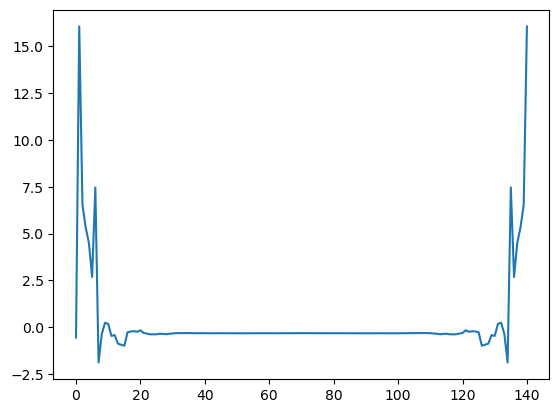

In [ ]:
y_fft = fft(y)
plt.plot(y_fft)

In [ ]:
end

13